#Importando pacotes

In [2]:
pip install git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-dgdajcom
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-dgdajcom
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+619.g5c3f9b34e-cp37-cp37m-linux_x86_64.whl size=17670973 sha256=52e04f0cdd931b9269dfa56138c7bf4adc2c794876c312b39ecb9e3768d5d3cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbgb2fx9/wheels/5c/ab/d8/d9505a18dd992621edd24cfddb9a1bd694dee85c065c0a6e57
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from sklearn.metrics import mean_squared_error
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

#Importando os dados

In [4]:
dados = pd.read_excel('Teste_USP.xlsx')

In [5]:
dados.head()

,Date,Trucks,IBCBR,Corrente de Comércio,Confiança,IPCA,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF
0,2003-01-01,4960.406782,100.48,34250.018637,97.8,2.20,384508.0,24967.907646,101.45,22,25.5,47.2,79.8,80.6,NaN,111.356,107.580547
1,2003-02-01,6247.814356,102.01,36024.354730,96.0,1.55,388320.0,25073.179942,109.05,20,26.5,48.0,79.7,80.3,NaN,114.589,105.382185
2,2003-03-01,5199.720503,101.76,35491.787728,93.1,1.22,386969.0,24800.866571,100.18,20,26.5,46.6,79.8,80.1,NaN,109.121,98.641268
3,2003-04-01,5416.424894,100.95,34301.013803,91.1,0.94,383307.0,24512.253853,90.84,20,26.5,46.6,79.5,79.9,NaN,96.720,101.280944
4,2003-05-01,5637.510125,99.79,38008.220507,88.9,0.65,386300.0,25033.870618,87.33,21,26.5,46.3,77.8,79.2,NaN,92.504,97.286746


#Substituindo os "NANS" pela media dos valores de cada coluna


In [6]:
# convertemos para o formato Numpy e ignoramos a última coluna (classe)
X = np.array(dados[dados.columns[1:dados.shape[1]]], dtype = float) 
# calculamos a média de cada atributo e armazenamos em um vetor
# Usamos a função nanmean que calcula a média ignorando os Nan
averages = np.nanmean(X, axis = 0) # veja https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html
for i in np.arange(0, X.shape[0]):
    for j in np.arange(0, X.shape[1]):
        if(np.isnan(X[i,j]) == True): # verificar se é uma entrada com Nan
            X[i,j] = averages[j] # insere a média
print(X)

[[4.96040678e+03 1.00480000e+02 3.42500186e+04 ... 8.57569620e+01
  1.11356000e+02 1.07580547e+02]
 [6.24781436e+03 1.02010000e+02 3.60243547e+04 ... 8.57569620e+01
  1.14589000e+02 1.05382185e+02]
 [5.19972050e+03 1.01760000e+02 3.54917877e+04 ... 8.57569620e+01
  1.09121000e+02 9.86412681e+01]
 ...
 [1.17685466e+04 1.39110000e+02 7.65262569e+04 ... 8.34000000e+01
  6.06050000e+01 1.48802389e+02]
 [1.12040587e+04 1.30508190e+02 7.79774700e+04 ... 8.76000000e+01
  5.80570000e+01 1.48802389e+02]
 [8.53507890e+03 1.30508190e+02 5.63884912e+04 ... 8.92000000e+01
  5.90350000e+01 1.48802389e+02]]


In [7]:
lista = list(dados.drop_duplicates())
lista = lista[1:17]
data = pd.DataFrame(X)
data.columns = lista

In [8]:
data['Date']= dados['Date']
lista2 = list(dados.drop_duplicates())
data = data[lista2]
data.index = pd.to_datetime(data.Date)
data.drop(columns= ['Date'], inplace=True)


In [9]:
x = []
y = data['IPCA'].dropna()
for i in data['IPCA']:
  x.append(i)

In [10]:
sum = 0
tamanho = 0
for i in x:
  sum += i
  tamanho +=1
  media = sum / tamanho 


In [11]:
media

0.46990990990991

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223 entries, 2003-01-01 to 2021-07-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Trucks                223 non-null    float64
 1   IBCBR                 223 non-null    float64
 2   Corrente de Comércio  223 non-null    float64
 3   Confiança             223 non-null    float64
 4   IPCA                  223 non-null    float64
 5   Credito               223 non-null    float64
 6   Consumo de Energia    223 non-null    float64
 7   IC                    223 non-null    float64
 8   du                    223 non-null    float64
 9   Selic                 223 non-null    float64
 10  PMC                   223 non-null    float64
 11  PIM                   223 non-null    float64
 12  NUCI                  223 non-null    float64
 13  IAE                   223 non-null    float64
 14  E                     223 non-null    float64
 15  FBKF

In [13]:
#data.index = pd.to_datetime(data.Date)

#Transformação logarítmica dos dados

In [14]:
data[lista] = data[lista].apply(lambda x: np.log(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
x = data['IPCA']
data = data.drop(['IPCA'], axis =1)


In [16]:
ipca = []
for i in x:
  ipca.append(np.log(i))

data['IPCA'] = ipca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223 entries, 2003-01-01 to 2021-07-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Trucks                223 non-null    float64
 1   IBCBR                 223 non-null    float64
 2   Corrente de Comércio  223 non-null    float64
 3   Confiança             223 non-null    float64
 4   Credito               223 non-null    float64
 5   Consumo de Energia    223 non-null    float64
 6   IC                    223 non-null    float64
 7   du                    223 non-null    float64
 8   Selic                 223 non-null    float64
 9   PMC                   223 non-null    float64
 10  PIM                   223 non-null    float64
 11  NUCI                  223 non-null    float64
 12  IAE                   223 non-null    float64
 13  E                     223 non-null    float64
 14  FBKF                  223 non-null    float64
 15  IPCA

In [18]:
data

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Date,,,,,,,,,,,,,,,,
2003-01-01,8.509243,4.609959,10.441442,4.582925,12.859720,10.125347,4.619566,3.091042,3.238678,3.854394,4.379524,4.389499,4.451517,4.712732,4.678240,-0.237677
2003-02-01,8.739987,4.625071,10.491951,4.564348,12.869585,10.129554,4.691806,2.995732,3.277145,3.871201,4.378270,4.385770,4.451517,4.741352,4.657594,-0.824955
2003-03-01,8.556360,4.622617,10.477057,4.533674,12.866100,10.118634,4.606969,2.995732,3.277145,3.841601,4.379524,4.383276,4.451517,4.692457,4.591490,-1.615200
2003-04-01,8.597191,4.614625,10.442930,4.511958,12.856592,10.106928,4.509100,2.995732,3.277145,3.841601,4.375757,4.380776,4.451517,4.571820,4.617898,NaN
2003-05-01,8.637198,4.603068,10.545558,4.487512,12.864370,10.127985,4.469694,3.044522,3.277145,3.835142,4.354141,4.371976,4.451517,4.527252,4.577663,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,9.224006,4.931087,11.239218,4.448516,15.227832,10.649545,5.793684,3.135494,1.011601,4.558079,4.472781,4.360548,4.345103,4.225110,5.155246,NaN
2021-04-01,9.197865,4.939569,11.256319,4.490881,15.233178,10.633169,5.805737,2.995732,1.011601,4.606170,4.457830,4.339902,4.365643,4.194688,4.956780,NaN
2021-05-01,9.373186,4.935265,11.245389,4.548600,15.244912,10.616003,5.816724,3.044522,1.252763,4.620059,4.471639,4.354141,4.423648,4.104377,5.002619,NaN


In [19]:
data.fillna(media, inplace=True)


In [20]:
data1 = data
data = data.query('Date <"2020-07-01"')

In [21]:
data

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Date,,,,,,,,,,,,,,,,
2003-01-01,8.509243,4.609959,10.441442,4.582925,12.859720,10.125347,4.619566,3.091042,3.238678,3.854394,4.379524,4.389499,4.451517,4.712732,4.678240,-0.237677
2003-02-01,8.739987,4.625071,10.491951,4.564348,12.869585,10.129554,4.691806,2.995732,3.277145,3.871201,4.378270,4.385770,4.451517,4.741352,4.657594,-0.824955
2003-03-01,8.556360,4.622617,10.477057,4.533674,12.866100,10.118634,4.606969,2.995732,3.277145,3.841601,4.379524,4.383276,4.451517,4.692457,4.591490,-1.615200
2003-04-01,8.597191,4.614625,10.442930,4.511958,12.856592,10.106928,4.509100,2.995732,3.277145,3.841601,4.375757,4.380776,4.451517,4.571820,4.617898,0.469910
2003-05-01,8.637198,4.603068,10.545558,4.487512,12.864370,10.127985,4.469694,3.044522,3.277145,3.835142,4.354141,4.371976,4.451517,4.527252,4.577663,0.469910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,8.995845,4.937634,11.126971,4.562263,15.064247,10.603567,5.330881,2.944439,1.446919,4.581902,4.471639,4.333361,4.521789,4.295093,5.045572,0.469910
2020-03-01,8.748371,4.888091,11.132401,4.495355,15.092273,10.588733,5.286852,3.091042,1.321756,4.555980,4.390739,4.321480,4.414010,4.384237,4.933738,0.469910
2020-04-01,8.291232,4.788241,11.176682,4.014580,15.092275,10.509029,5.302359,2.995732,1.321756,4.375757,4.178992,4.048301,3.681351,4.424212,4.626381,0.469910


#ARIMAX 

##Preparando os dados

In [22]:
y = data['Trucks']
y


Date
2003-01-01    8.509243
2003-02-01    8.739987
2003-03-01    8.556360
2003-04-01    8.597191
2003-05-01    8.637198
                ...   
2020-02-01    8.995845
2020-03-01    8.748371
2020-04-01    8.291232
2020-05-01    8.503330
2020-06-01    9.084983
Name: Trucks, Length: 210, dtype: float64

In [23]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [24]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [25]:
exog = data['IBCBR']
import statsmodels.api as sm
aic_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
                                       order=param,
                                       seasonal_order=param_seasonal, exog = exog)
        results = mod.fit()
        aic_list.append('ARIMA{}x{} - AIC{} - P.VALOR {}'.format(param, param_seasonal, results.aic, results.pvalues))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [26]:
aic_list


['ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC158.29519437946232 - P.VALOR IBCBR     0.000000e+00\nsigma2    1.289146e-14\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC1.9500194821069101 - P.VALOR IBCBR       0.000000e+00\nma.S.L12    1.005296e-39\nsigma2      3.777062e-26\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC-24.50361912896139 - P.VALOR IBCBR     5.013494e-25\nsigma2    9.161249e-22\ndtype: float64',
 'ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC-38.53756972173352 - P.VALOR IBCBR       7.952893e-26\nma.S.L12    1.574406e-06\nsigma2      4.479783e-25\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC3.703331567217525 - P.VALOR IBCBR       0.000000e+00\nar.S.L12    2.668349e-51\nsigma2      3.646163e-19\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC-27.784112478545808 - P.VALOR IBCBR       0.000000e+00\nar.S.L12    1.351610e-10\nma.S.L12    8.483458e-19\nsigma2      3.111746e-32\ndtype: float64',
 'ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC-37.341010354013605 - P.VALOR IBCBR   

##MODELO

In [27]:
data.corr()

,Trucks,IBCBR,Corrente de Comércio,Confiança,Credito,Consumo de Energia,IC,du,Selic,PMC,PIM,NUCI,IAE,E,FBKF,IPCA
Trucks,1.000000,0.434102,0.021655,0.631318,0.073159,0.171967,-0.296812,0.068942,-0.253067,0.249658,0.810348,0.636620,0.102825,-0.695549,0.672212,0.111479
IBCBR,0.434102,1.000000,0.821273,-0.080477,0.896465,0.940011,0.540042,0.003529,-0.634729,0.961423,0.559856,-0.072083,0.064866,-0.678918,0.921172,-0.012546
Corrente de Comércio,0.021655,0.821273,1.000000,-0.343250,0.918474,0.917861,0.800882,-0.022200,-0.678920,0.886122,0.128190,-0.460450,0.024407,-0.309793,0.610019,-0.047094
Confiança,0.631318,-0.080477,-0.343250,1.000000,-0.428799,-0.299422,-0.571052,0.034917,0.029348,-0.286941,0.618757,0.817925,0.615585,-0.420453,0.129014,0.158747
Credito,0.073159,0.896465,0.918474,-0.428799,1.000000,0.979728,0.810711,-0.011412,-0.707601,0.977202,0.144164,-0.487825,-0.061023,-0.362897,0.707141,-0.062285
Consumo de Energia,0.171967,0.940011,0.917861,-0.299422,0.979728,1.000000,0.765850,-0.000760,-0.700045,0.983624,0.277146,-0.353942,0.023473,-0.445710,0.768957,-0.040354
IC,-0.296812,0.540042,0.800882,-0.571052,0.810711,0.765850,1.000000,-0.032660,-0.600179,0.711898,-0.306547,-0.718065,-0.084218,0.168621,0.279892,-0.147414
du,0.068942,0.003529,-0.022200,0.034917,-0.011412,-0.000760,-0.032660,1.000000,0.034744,-0.001703,0.050501,0.048154,0.020695,-0.009279,0.080604,0.070175
Selic,-0.253067,-0.634729,-0.678920,0.029348,-0.707601,-0.700045,-0.600179,0.034744,1.000000,-0.697616,-0.106431,0.385119,-0.025761,0.285418,-0.518192,-0.037627
PMC,0.249658,0.961423,0.886122,-0.286941,0.977202,0.983624,0.711898,-0.001703,-0.697616,1.000000,0.324631,-0.313488,-0.018031,-0.493113,0.827376,-0.046382


Usando a pesquisa de correlação e fazendo alguns testes, identificamos o conjunto de parâmetros que produzirá o modelo de melhor ajuste para nossos dados de série temporal. Podemos prosseguir para analisar este modelo específico com mais profundidade.


In [28]:
exorg = data['IBCBR']

In [29]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order = (1,0,1,12), exog=exorg)
results = mod.fit()



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:584: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [30]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Trucks   No. Observations:                  210
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 208.265
Date:                            Tue, 17 Aug 2021   AIC                           -404.529
Time:                                    17:07:28   BIC                           -384.475
Sample:                                01-01-2003   HQIC                          -396.421
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IBCBR          4.3589      0.509      8.564      0.000       3.361       5.357
ar.L1          0.4553      0.217   

results.summary resulta na saída de SARIMAX que retorna uma quantidade significativa de informações, mas vamos concentrar nossa atenção na tabela de coeficientes. A coluna de coeficiente mostra o peso (ou seja, importância) de cada recurso e como cada um impacta a série temporal. O P> | z | nos informa sobre a importância de cada peso. Aqui, cada peso tem um valor p inferior ou próximo a 0,05, portanto, é melhor mante-los em nosso modelo.

O Ljung-Box nos ajuda a determinar se os erros residuais da regressão são autocorrelacionados de forma estatisticamente significativa. Nesse caso, o valor de p é 0,88, o que é significativamente maior do que 0,05 (limite de confiança de 95%). Portanto, aceitamos a hipótese nula do teste Ljung-Box de que os erros residuais não são autocorrelacionados.

**O** **teste** **Ljung-Box** **pode** **ser** **definido** **como:**

H0: Os dados são distribuídos de forma independente (ou seja, as correlações na população da qual a amostra é retirada são 0, de modo que quaisquer correlações observadas nos dados resultam da aleatoriedade do processo de amostragem).

Ha: Os dados não são distribuídos de forma independente; eles exibem correlação serial.


##Sumário

Ao ajustar modelos ARIMA sazonais é importante executar o diagnóstico do modelo para garantir que nenhuma das suposições feitas pelo modelo foi violada. O objeto plot_diagnostics nos permite gerar diagnósticos de modelo rapidamente e investigar qualquer comportamento incomum.

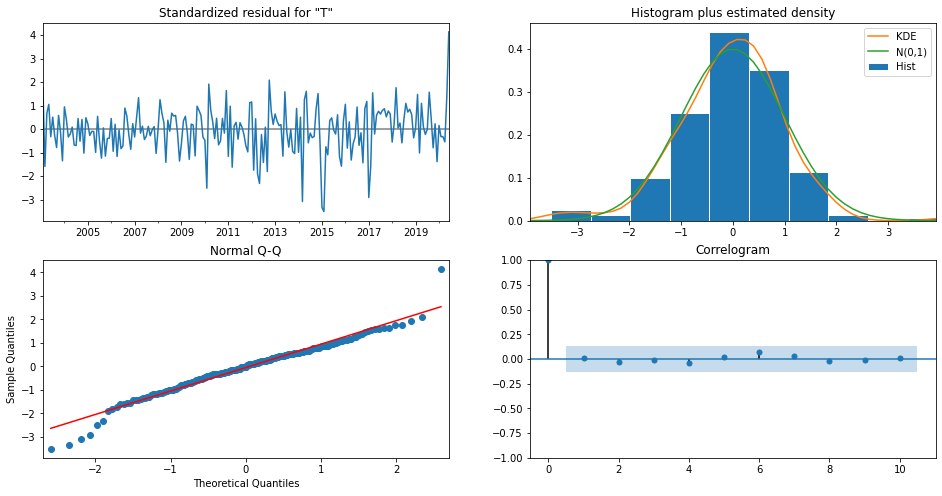

In [31]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

Nossa principal preocupação é garantir que os resíduos de nosso modelo não estejam correlacionados e sejam normalmente distribuídos com média zero. Se o modelo ARIMA sazonal não satisfizer essas propriedades, é uma boa indicação de que pode ser melhorado.

Neste caso, nosso diagnóstico do modelo sugere que os resíduos são normalmente distribuídos com base no seguinte:

No gráfico superior direito, vemos que a linha laranja do KDE segue de perto a linha N (0,1) (onde N (0,1)) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1) . Esta é uma boa indicação de que os resíduos estão normalmente distribuídos.

O gráfico na parte inferior esquerda mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras obtidas de uma distribuição normal padrão com N (0, 1), tendo apenas um leve desvio no inicio e no fim , isto é uma indicação de que os resíduos são normalmente distribuídos.
Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco (Aleatoriamente distribuidos), isso é confirmado pelo gráfico de autocorrelação (correlogram) na parte inferior direita, que mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmos.
Essas observações nos levam a concluir que nosso modelo produz um ajuste satisfatório que pode nos ajudar a entender nossos dados de série temporal e prever valores futuros.


##Previsões

Obtivemos um modelo para nossas séries temporais que agora pode ser usado para produzir previsões.


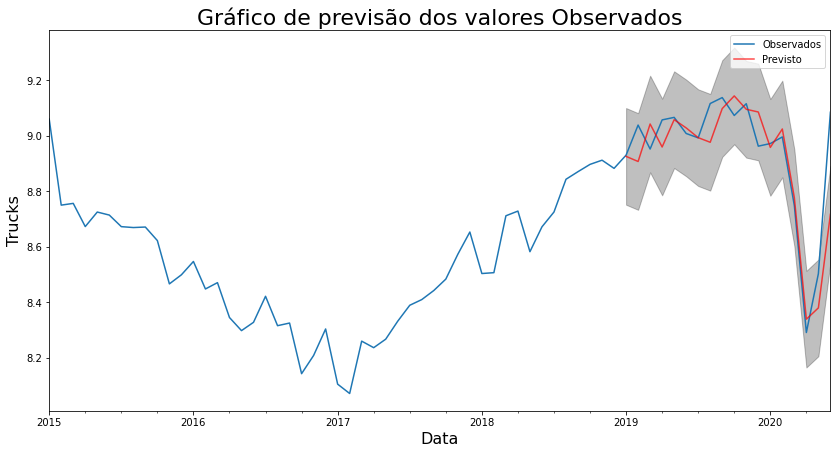

In [32]:
plt.figure(figsize=(14,7))
plt.title('Gráfico de previsão dos valores Observados', fontsize = 22)
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Observados')
pred.predicted_mean.plot(ax=ax, label='Previsto', color='r', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k',alpha=0.25)
plt.legend()
ax.set_xlabel('Data',fontsize=16)
ax.set_ylabel('Trucks',fontsize=16)
plt.show()

In [33]:
data2 = data1.query('Date > "2020-07-01"')
exog = data2['IBCBR']

Text(0, 0.5, 'Trucks')

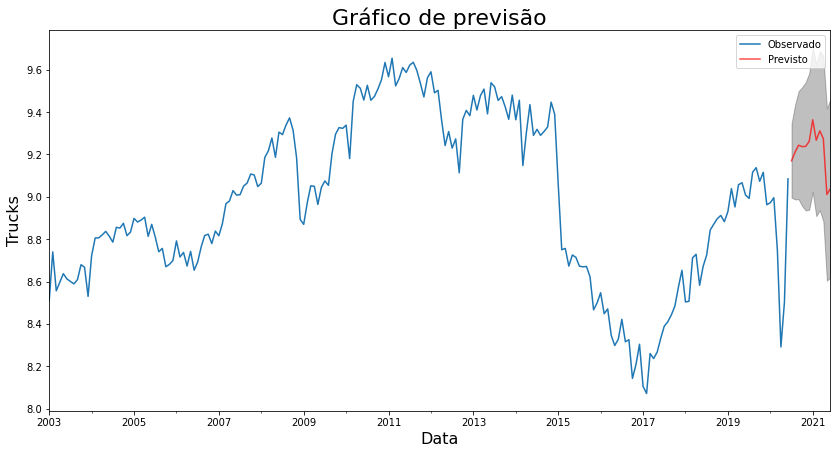

In [34]:
pred_uc = results.get_forecast(steps = 12, exog = exog )
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observado',figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Previsto', color='r', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color='k',alpha=0.25)
#fig = plt.plot(x,linestyle='--',color='green',label='Reais')

plt.legend()
plt.title('Gráfico de previsão', fontsize = 22)
ax.set_xlabel('Data',fontsize=16)
ax.set_ylabel('Trucks',fontsize=16)

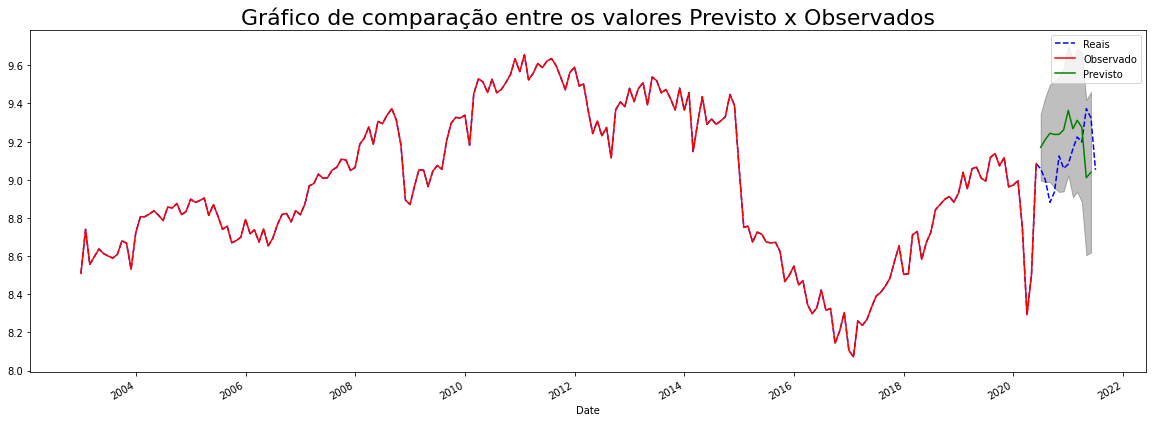

In [35]:
x = data1['Trucks']
plt.figure(figsize=(20,7))
plt.title('Gráfico de comparação entre os valores Previsto x Observados', fontsize = 22)
fig = plt.plot(x,linestyle='--',color='b',label='Reais')
ax = y.plot(label='Observado', color='red')
pred_uc.predicted_mean.plot(ax=ax, color='green', label='Previsto')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color='k',alpha=0.25)
plt.legend()

##Erro quadratico médio

In [48]:
x = data1.query('Date > "2020-07-01"')
x = x['Trucks']

In [49]:
pred = pred_uc.predicted_mean
valores_previstos = []
for z in pred:
  valores_previstos.append(z)

In [50]:
import sklearn.metrics as metrics


In [51]:
metrics.mean_squared_error(x, valores_previstos)

0.03934824623518007

O erro quadratico médio é de 0.039, um valor proximo de zero. Isso significa que os valores previstos são muito proximos dos valores originais.

##Métricas dos erros

In [40]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [52]:
variance_score = metrics.explained_variance_score(x, valores_previstos)
mean_absolute_error = metrics.mean_absolute_error(x, valores_previstos)

In [54]:
print(f'variance score = {variance_score}\nmean absolute error = {mean_absolute_error}')

variance score = -0.45977186455483143
mean absolute error = 0.1716866487751411


##Erro absoluto entre os valores reais e previstos

In [55]:
observado_x_previsto = []
for i in range(x.size):
  observado_x_previsto.append(abs(x[i] - valores_previstos[i]))

In [56]:
observado_x_previsto = pd.DataFrame(observado_x_previsto, columns=['Erro absoluto entre os valores reais e previstos'])

In [57]:
observado_x_previsto

,Erro absoluto entre os valores reais e previstos
0,0.171127
1,0.329573
2,0.307100
3,0.112712
4,0.178646
5,0.179357
6,0.201398
7,0.043021
8,0.113605
9,0.098085


In [85]:
sumx = 0
for i in x:
  sumx+=i #soma dos valores originais

sum_prev = 0
for i in valores_previstos:
  sum_prev+=i#soma dos valores previstos

erro_absoluto = sumx - sum_prev # erro absoluto do acumalado das variáveis
print(f'Soma dos valores originais: {round(sumx,2)}\nSoma dos valores previstos: {round(sum_prev, 2)}\nerro absoluto: {round(erro_absoluto, 2)}')

Soma dos valores originais: 109.42
Soma dos valores previstos: 110.63
erro absoluto: -1.21


#VAR



In [63]:
df = data

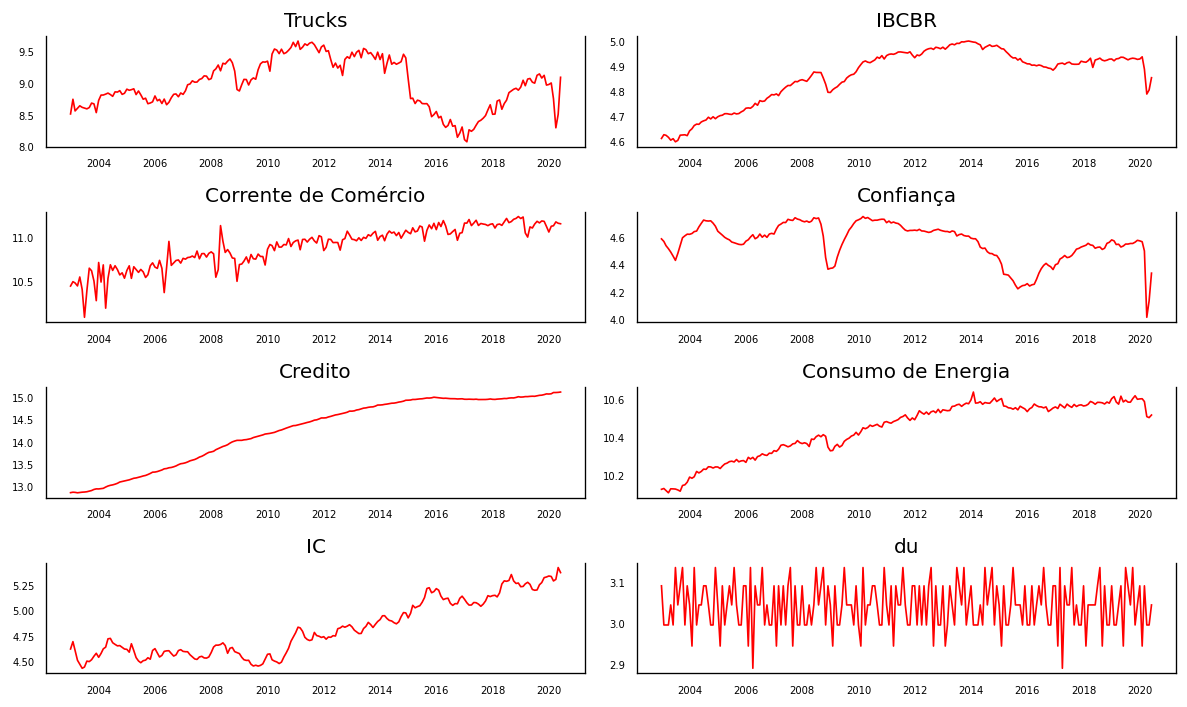

In [64]:
#Visualizando a série temporal
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [65]:
#Testando Causalidade usando o Teste de Causalidade de Granger
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Verifique a causalidade de Granger de todas as combinações possíveis da série temporal.
    As linhas são a variável de resposta, as colunas são preditores. Os valores da tabela
    são os valores P. Valores de P menores que o nível de significância (0,05), implica
    a hipótese nula de que os coeficientes dos valores anteriores correspondentes são
    zero, ou seja, o X não faz com que Y possa ser rejeitado.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Trucks_x,IBCBR_x,Corrente de Comércio_x,Confiança_x,Credito_x,Consumo de Energia_x,IC_x,du_x,Selic_x,PMC_x,PIM_x,NUCI_x,IAE_x,E_x,FBKF_x,IPCA_x
Trucks_y,1.0000,0.0009,0.3919,0.0000,0.1633,0.0021,0.0376,0.0084,0.0550,0.0004,0.0184,0.0000,0.0006,0.0532,0.0026,0.0000
IBCBR_y,0.2007,1.0000,0.0779,0.0086,0.0935,0.1804,0.0006,0.3174,0.2318,0.5717,0.3828,0.0022,0.1293,0.0050,0.0637,0.0000
Corrente de Comércio_y,0.5118,0.0000,1.0000,0.1157,0.0000,0.0000,0.0000,0.1062,0.0005,0.0000,0.3975,0.0536,0.5389,0.0689,0.0071,0.5845
Confiança_y,0.1476,0.0000,0.0934,1.0000,0.0014,0.0123,0.0016,0.3211,0.0001,0.0050,0.0156,0.0000,0.0000,0.0000,0.0058,0.0000
Credito_y,0.0000,0.0000,0.0530,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0586,0.0000,0.0000,0.0005
Consumo de Energia_y,0.0000,0.0000,0.1766,0.0000,0.0182,1.0000,0.0940,0.0004,0.0595,0.0000,0.0000,0.0094,0.0000,0.0070,0.0000,0.0007
IC_y,0.1800,0.0023,0.0164,0.0004,0.0001,0.0150,1.0000,0.0659,0.0370,0.0005,0.0411,0.0003,0.0004,0.1616,0.0076,0.0325
du_y,0.0026,0.0518,0.0216,0.4054,0.0000,0.1009,0.5026,1.0000,0.0627,0.2337,0.0657,0.1262,0.3764,0.3939,0.0033,0.1632
Selic_y,0.0000,0.0000,0.0227,0.0000,0.0016,0.0000,0.0016,0.0052,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006
PMC_y,0.0014,0.0000,0.3520,0.0215,0.0732,0.0286,0.0009,0.0879,0.0356,1.0000,0.0043,0.0002,0.0094,0.0003,0.0004,0.0000


In [66]:
#Cointegration Test
#Ajuda a estabelecer a presença de uma conexão estatisticamente significativa entre duas ou mais séries temporais.
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Trucks ::  968.59    > nan       =>   False
IBCBR  ::  818.9     > nan       =>   False
Corrente de Comércio ::  676.61    > nan       =>   False
Confiança ::  561.71    > nan       =>   False
Credito ::  469.48    > 311.1288  =>   True
Consumo de Energia ::  386.86    > 263.2603  =>   True
IC     ::  307.72    > 219.4051  =>   True
du     ::  242.59    > 179.5199  =>   True
Selic  ::  189.63    > 143.6691  =>   True
PMC    ::  146.58    > 111.7797  =>   True
PIM    ::  104.72    > 83.9383   =>   True
NUCI   ::  71.26     > 60.0627   =>   True
IAE    ::  45.17     > 40.1749   =>   True
E      ::  26.76     > 24.2761   =>   True
FBKF   ::  13.85     > 12.3212   =>   True
IPCA   ::  5.8       > 4.1296    =>   True


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:651: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning,


In [67]:
#Dividindo a série em dados de treinamento e teste
nobs = 20
df_train, df_test = df[0:-nobs], df[-nobs:]

#Checando o tamanho
print(df_train.shape) 
print(df_test.shape) 

(190, 16)
(20, 16)


In [68]:
#Verificando se há estacionariedade e tornando a série temporal estacionária
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [69]:
#Chamando o adfuller_test () em cada série.
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Trucks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8159
 No. Lags Chosen       = 0
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.3726. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IBCBR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2715
 No. Lags Chosen       = 2
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.1813. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Corrente de Comércio" 
    -----------------------------------------------
 Null Hypothesi

In [70]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [71]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Trucks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5637
 No. Lags Chosen       = 0
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IBCBR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7496
 No. Lags Chosen       = 1
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Corrente de Comércio" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [72]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [73]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Trucks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4158
 No. Lags Chosen       = 6
 Critical value 1%     = -3.467
 Critical value 5%     = -2.878
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IBCBR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.605
 No. Lags Chosen       = 15
 Critical value 1%     = -3.469
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Corrente de Comércio" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [74]:
#Para selecionar a ordem certa do modelo VAR, ajustamos iterativamente as ordens crescentes do modelo VAR e escolhemos a ordem que dá um modelo com 
#menos AIC
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -109.87999769025015
BIC :  -105.18020333846165
FPE :  1.9196459597563105e-48
HQIC:  -107.97563920808652 

Lag Order = 2
AIC :  -111.83023021568565
BIC :  -102.67327191611268
FPE :  2.878187975524325e-49
HQIC:  -108.11948203054445 

Lag Order = 3
AIC :  -112.75104716924761
BIC :  -99.1037014024292
FPE :  1.3265828970816262e-49
HQIC:  -107.22011308069165 

Lag Order = 4
AIC :  -113.42079029116002
BIC :  -95.24941426989183
FPE :  9.183303388142474e-50
HQIC:  -106.0557050695291 

Lag Order = 5
AIC :  -114.13427981352078
BIC :  -91.404804108152
FPE :  7.742007707855966e-50
HQIC:  -104.92090641401744 

Lag Order = 6
AIC :  -115.50624543917999
BIC :  -88.18416643729435
FPE :  4.879450255091217e-50
HQIC:  -104.43027215973964 

Lag Order = 7
AIC :  -117.86960282946735
BIC :  -85.91997502544186
FPE :  2.0277042917485025e-50
HQIC:  -104.91654041112574 

Lag Order = 8
AIC :  -120.93582589836006
BIC :  -84.32325400815232
FPE :  1.0880049790800252e-50
HQIC:  -106.09100456680031 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:537: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [75]:
#Treinando o modelo VAR da ordem selecionada (p)
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Aug, 2021
Time:                     17:18:25
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -95.2494
Nobs:                     184.000    HQIC:                  -106.056
Log likelihood:           7297.36    FPE:                9.18330e-50
AIC:                     -113.421    Det(Omega_mle):     7.25930e-52
--------------------------------------------------------------------
Results for equation Trucks
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.000643         0.006975            0.092           0.927
L1.Trucks                      -0.920076         0.097703           -9.417           0.000
L1.IBCBR           

In [76]:
#Verificando a correlação serial de resíduos (erros) usando a estatística de Durbin Watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Trucks : 2.05
IBCBR : 1.97
Corrente de Comércio : 2.2
Confiança : 1.94
Credito : 2.03
Consumo de Energia : 2.07
IC : 1.99
du : 2.05
Selic : 1.93
PMC : 1.98
PIM : 2.14
NUCI : 2.07
IAE : 1.95
E : 2.03
FBKF : 2.17
IPCA : 2.26


In [77]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Dados de entrada para previsão
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-3.61070254e-02, -2.68858563e-02,  7.67049333e-05,
         2.71177280e-02, -8.19421050e-03,  1.95638961e-02,
        -3.53414933e-02,  4.65200156e-02,  0.00000000e+00,
        -4.41695299e-03, -1.29402597e-01, -2.65755038e-03,
         4.85716312e-02, -3.36936400e-03, -1.14264091e-01,
         3.34706827e+00],
       [ 6.45540896e-02,  1.57848518e-03, -8.83267735e-02,
        -4.37154508e-03,  1.15140312e-02, -1.04908483e-02,
         1.27954154e-02, -2.06825306e-03,  0.00000000e+00,
         3.45025118e-02, -2.32638331e-03,  1.05523829e-02,
         4.17943674e-03,  4.98596223e-03, -6.66655349e-02,
        -1.67353413e+00],
       [-9.05478265e-02, -1.25140209e-02,  6.08663340e-02,
        -1.96774710e-02, -5.30335314e-03, -1.64975814e-03,
         4.99288885e-02, -2.35506999e-01,  0.00000000e+00,
        -3.11602499e-02, -1.84967455e-02,  5.21999113e-03,
        -3.13888726e-02,  7.20928826e-03,  7.69599145e-03,
         0.00000000e+00],
       [-1.21944457e-03,  5.19657850e

In [78]:
# Previsão
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Trucks_2d,IBCBR_2d,Corrente de Comércio_2d,Confiança_2d,Credito_2d,Consumo de Energia_2d,IC_2d,du_2d,Selic_2d,PMC_2d,PIM_2d,NUCI_2d,IAE_2d,E_2d,FBKF_2d,IPCA_2d
Date,,,,,,,,,,,,,,,,
2018-11-01,-0.074214,0.003180,-0.327027,0.008351,0.004917,0.002940,0.103459,-0.241943,-0.023237,0.000837,0.010174,0.003656,0.026799,0.078073,0.018597,-0.326061
2018-12-01,0.199090,-0.001297,0.553224,-0.013722,0.004103,-0.010917,-0.031772,0.088823,0.007292,-0.007933,-0.035305,0.006049,-0.026960,0.017235,-0.143450,1.275591
2019-01-01,-0.071096,0.007367,-0.376702,0.000527,-0.002080,0.015678,0.006271,-0.000946,0.035278,0.016312,0.015869,-0.002759,0.012187,-0.016646,0.157810,-1.328730
2019-02-01,0.031701,-0.006648,0.141704,0.008455,-0.006999,0.006304,-0.008751,-0.034151,-0.043841,-0.013327,0.004413,0.004384,0.003210,0.001014,-0.042675,0.755378
2019-03-01,-0.161789,-0.006820,-0.120163,-0.005984,0.006770,-0.016276,-0.003715,0.057855,0.028533,0.006024,-0.012972,-0.007535,-0.017712,-0.021504,-0.088841,-0.453648
2019-04-01,0.124253,0.014069,0.065401,0.007073,-0.000969,-0.000589,0.018537,-0.045774,-0.017917,-0.005575,0.021796,0.005316,0.026840,0.018318,0.145767,-0.067880
2019-05-01,0.012214,-0.008431,0.100258,-0.010585,0.000422,0.006399,-0.020892,-0.005080,0.008958,0.007203,-0.013488,-0.003089,-0.032455,0.018242,-0.100870,0.620471
2019-06-01,-0.011635,0.004730,-0.150034,0.005621,0.000169,0.001656,0.031102,0.049805,0.008307,0.000116,-0.009174,0.003699,0.018905,-0.015469,0.040766,-0.481874
2019-07-01,0.001544,-0.008085,0.073299,-0.003452,-0.003523,-0.000619,-0.031467,-0.072100,-0.016971,-0.010803,0.011862,-0.001276,-0.001236,-0.012623,-0.027975,0.152429


In [79]:
#Invertendo a transformação para obter a previsão real
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [80]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

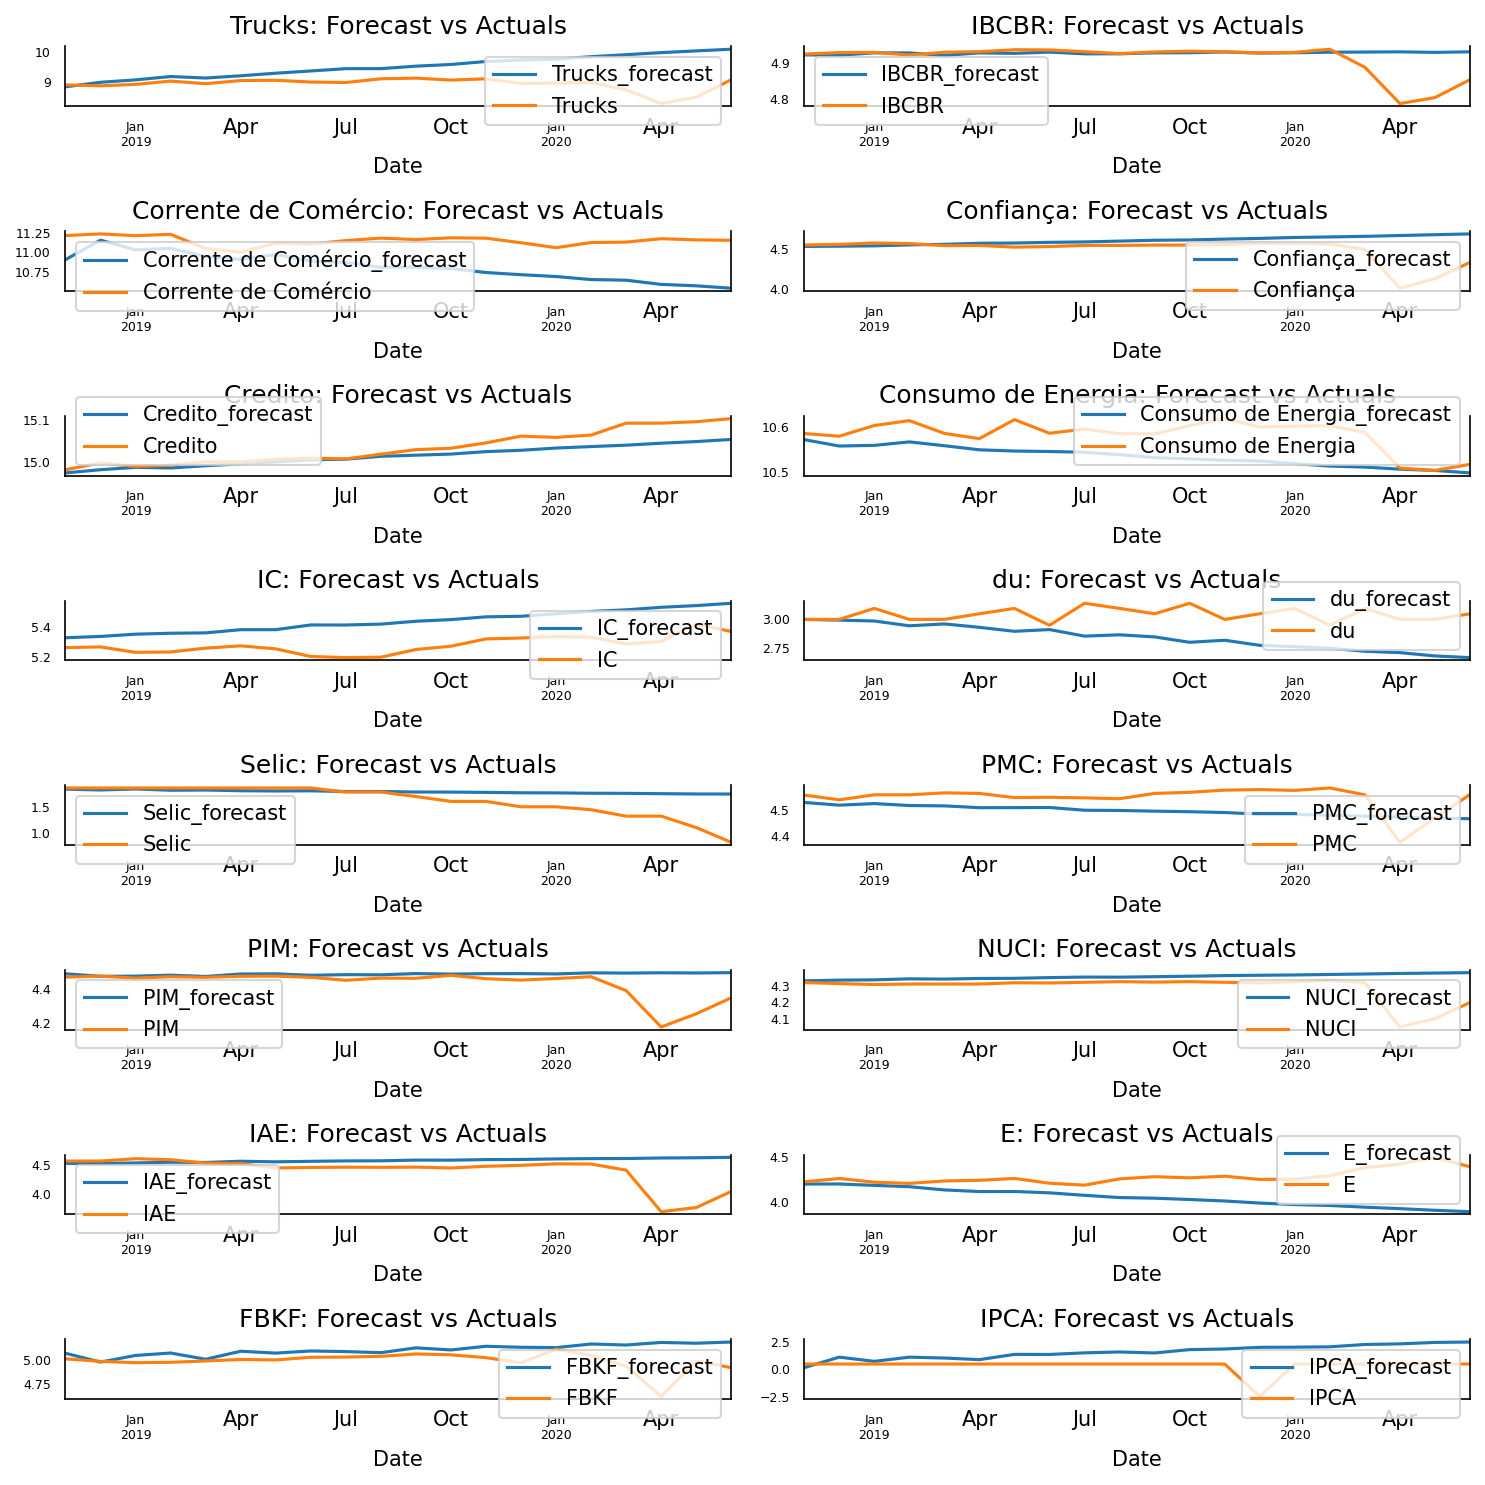

In [81]:
#Gráfico de previsão x reais
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [82]:
#Avaliando a previsão de trucks
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Trucks')
accuracy_prod = forecast_accuracy(df_results['Trucks_forecast'].values, df_test['Trucks'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Trucks
mape :  0.0658
me :  0.5732
mae :  0.5796
mpe :  0.065
rmse :  0.7431
corr :  -0.3539
minmax :  0.0593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
